In [44]:
import pandas as pd
import numpy as np

# Чтение данных

In [45]:
data = pd.read_csv('train.csv')
data.sample(n=5)  # посмотрим на 5 случайных строк

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
296,1,70.60,70.6,Male,0,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,No,Mailed check,1
880,71,100.20,7209,Male,0,Yes,Yes,Yes,No,Fiber optic,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),0
4328,15,30.20,469.65,Male,0,Yes,Yes,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Bank transfer (automatic),0
721,70,105.35,7511.9,Male,1,Yes,No,Yes,No,Fiber optic,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Credit card (automatic),0
2295,57,53.45,3053,Female,0,Yes,Yes,Yes,No,DSL,Yes,Yes,No,No,No,No,One year,No,Electronic check,0


In [46]:
# название колонок для числовых и категориальных признаков

# числовые признаки
numerical_columns = [
    'ClientPeriod',
    'MonthlySpending',
    'TotalSpent'
]

# категориальные признаки
catigorial_columns = [
    'Sex',
    'IsSeniorCitizen',
    'HasPartner',
    'HasChild',
    'HasPhoneService',
    'HasMultiplePhoneNumbers',
    'HasInternetService',
    'HasOnlineSecurityService',
    'HasOnlineBackup',
    'HasDeviceProtection',
    'HasTechSupportAccess',
    'HasOnlineTV',
    'HasMovieSubscription',
    'HasContractPhone',
    'IsBillingPaperless',
    'PaymentMethod'
]

# все признаки
feature_columns = numerical_columns + catigorial_columns

# целевой признак
target_column = 'Churn'

### Удалим все non'ы

Посмотрим есть ли незаполненные признаки (nan'ы)

In [47]:
data = data.replace('?', np.nan)
data = data.replace('', np.nan)
data = data.replace(' ', np.nan)

In [48]:
data.isna().sum()

ClientPeriod                0
MonthlySpending             0
TotalSpent                  9
Sex                         0
IsSeniorCitizen             0
HasPartner                  0
HasChild                    0
HasPhoneService             0
HasMultiplePhoneNumbers     0
HasInternetService          0
HasOnlineSecurityService    0
HasOnlineBackup             0
HasDeviceProtection         0
HasTechSupportAccess        0
HasOnlineTV                 0
HasMovieSubscription        0
HasContractPhone            0
IsBillingPaperless          0
PaymentMethod               0
Churn                       0
dtype: int64

Видно, что есть nun в колонке TotalSpent. Удалим эти строки с nan.

In [49]:
data = data.dropna()
data.isna().sum()

ClientPeriod                0
MonthlySpending             0
TotalSpent                  0
Sex                         0
IsSeniorCitizen             0
HasPartner                  0
HasChild                    0
HasPhoneService             0
HasMultiplePhoneNumbers     0
HasInternetService          0
HasOnlineSecurityService    0
HasOnlineBackup             0
HasDeviceProtection         0
HasTechSupportAccess        0
HasOnlineTV                 0
HasMovieSubscription        0
HasContractPhone            0
IsBillingPaperless          0
PaymentMethod               0
Churn                       0
dtype: int64

Посмотрим на типы данных

In [50]:
data.dtypes

ClientPeriod                  int64
MonthlySpending             float64
TotalSpent                   object
Sex                          object
IsSeniorCitizen               int64
HasPartner                   object
HasChild                     object
HasPhoneService              object
HasMultiplePhoneNumbers      object
HasInternetService           object
HasOnlineSecurityService     object
HasOnlineBackup              object
HasDeviceProtection          object
HasTechSupportAccess         object
HasOnlineTV                  object
HasMovieSubscription         object
HasContractPhone             object
IsBillingPaperless           object
PaymentMethod                object
Churn                         int64
dtype: object

Видно, что численные признак TotalSpent имеет тип object. Должно ли быть так?

In [51]:
data['TotalSpent'].head()

0    1026.35
1     1872.2
2       75.9
3       2570
4    6758.45
Name: TotalSpent, dtype: object

Очевидно тут числа, поэтому заменим поменяем тип с object на float

In [52]:
data['TotalSpent'] = data['TotalSpent'].astype(float)

# Анализ данных

In [203]:
from matplotlib import pyplot as plt
import seaborn as sns

### Гистограммы числовых признаков

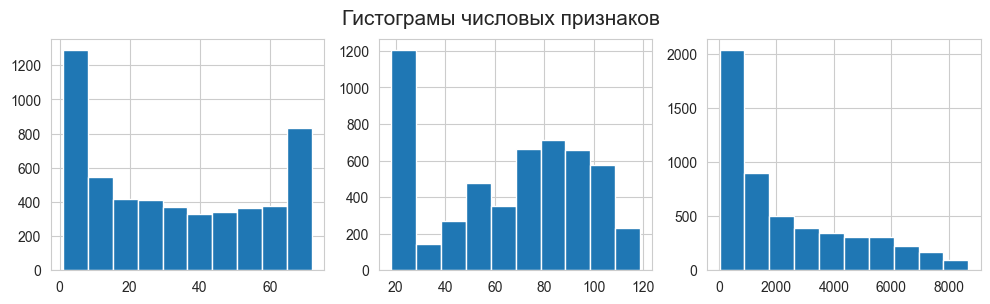

In [204]:
n = data[numerical_columns].shape[1]

fig, axes = plt.subplots(1, n, figsize=(12, 3))
fig.suptitle('Гистограмы числовых признаков', size=15)

for i in range(n):
    y = data[numerical_columns[i]]
    ax = axes[i]
    ax.hist(y, 10)
    # ax.add_title('Title')

### Количество каждого значения для каждого категориального признака

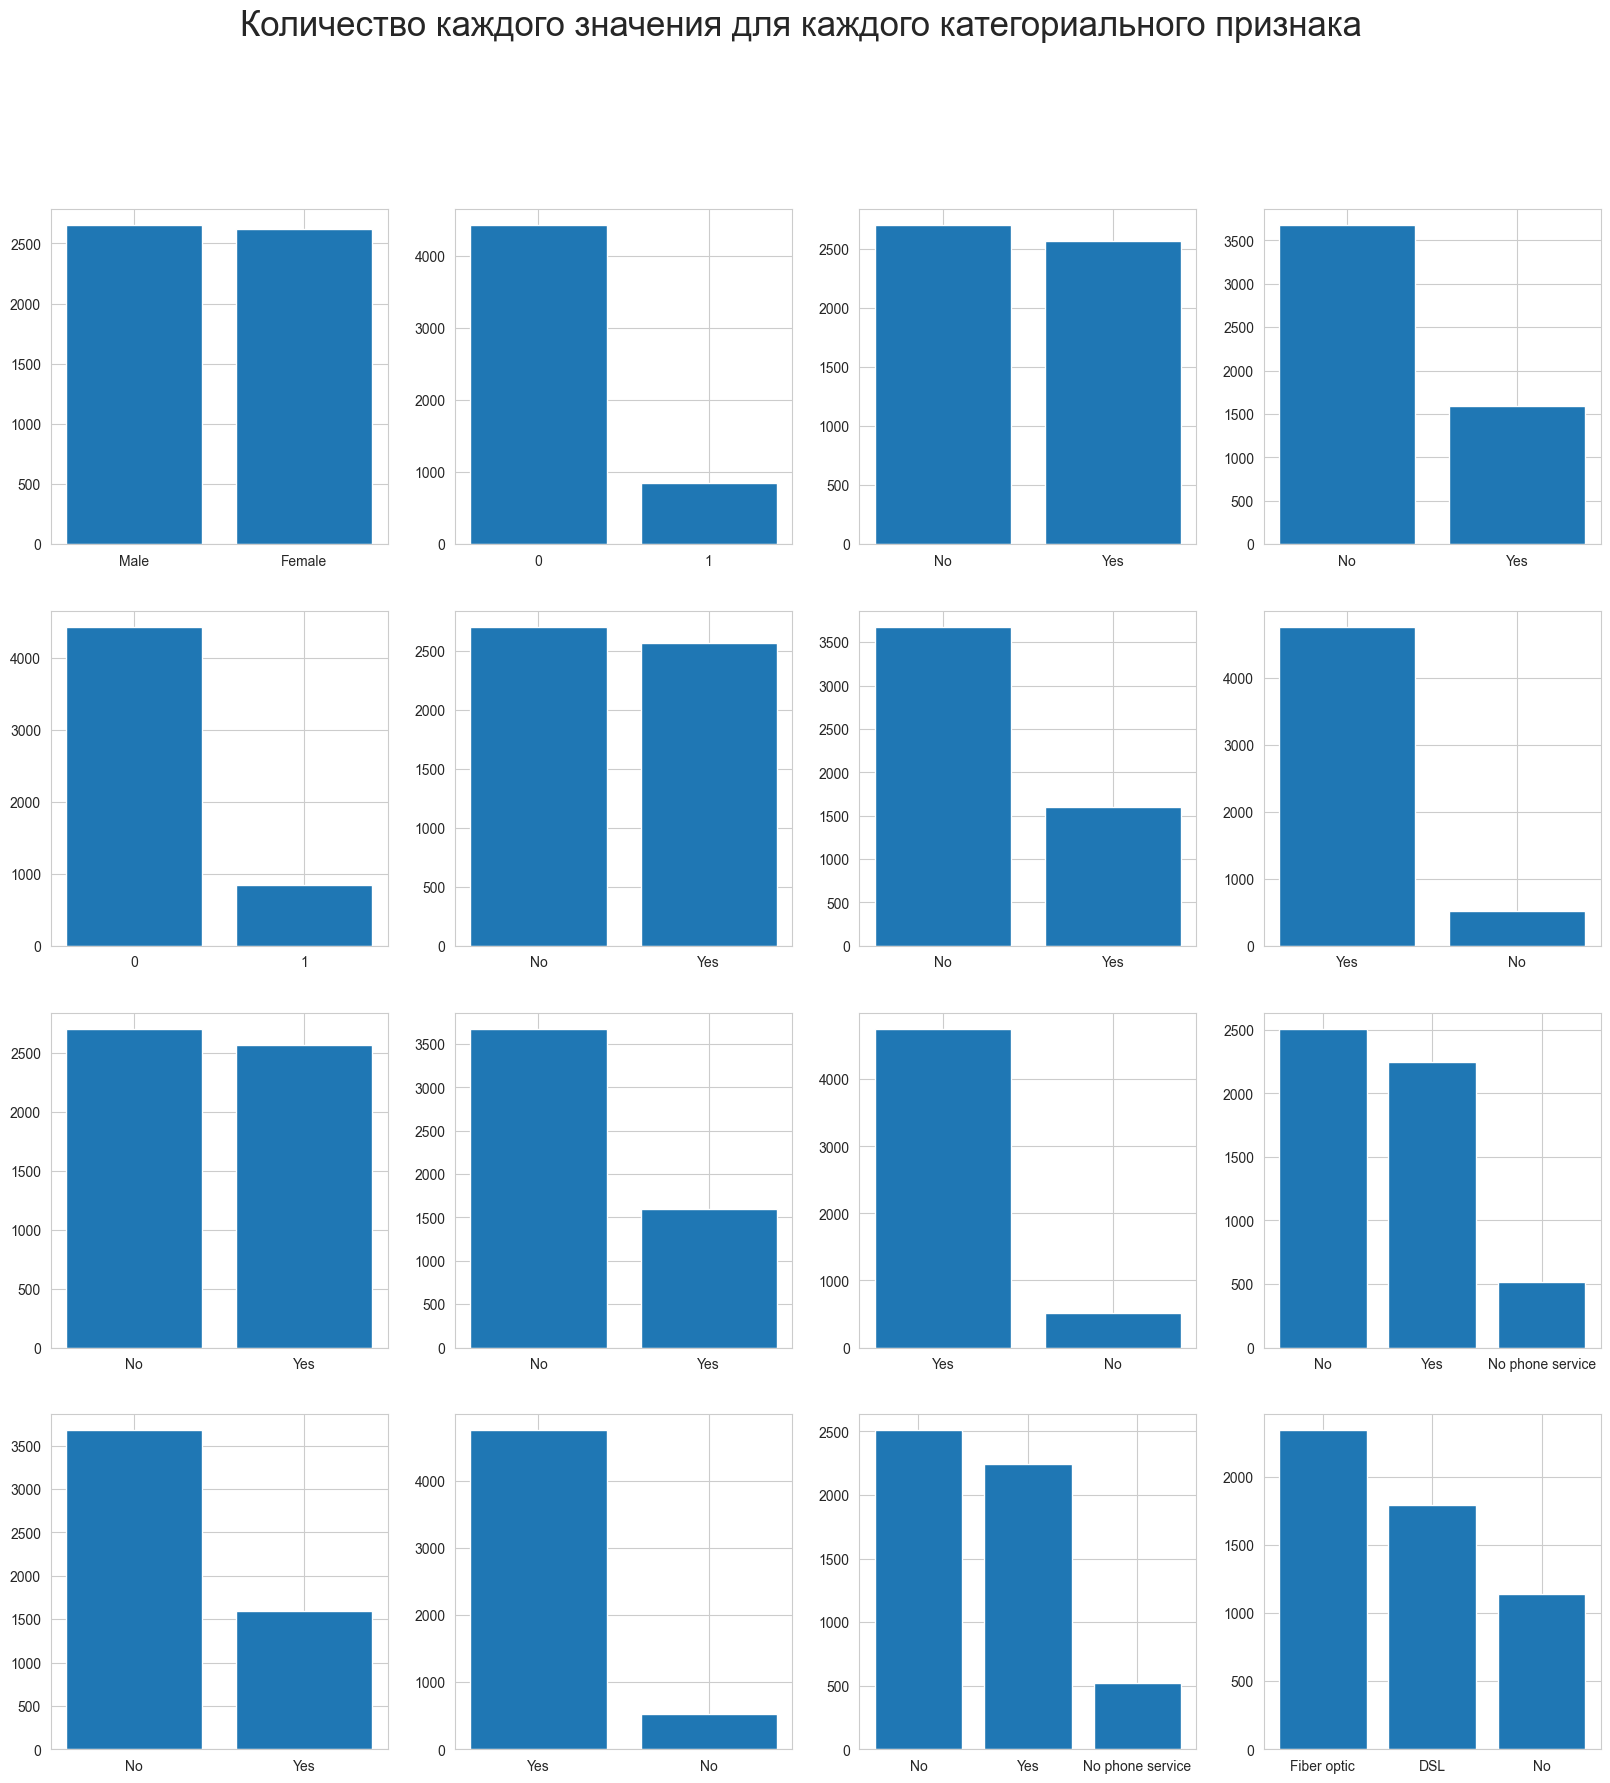

In [205]:
fig, axes = plt.subplots(4, 4, figsize=(20,20))
fig.suptitle('Количество каждого значения для каждого категориального признака', size=25)

for i in range(4):
    for j in range(4):
        this_data = data[catigorial_columns[i + j]].value_counts()
        ax = axes[i][j]
        ax.bar(this_data.index.values, this_data.values)
        ax.set_xticks(this_data.index.values)

### Распределение целевой переменной

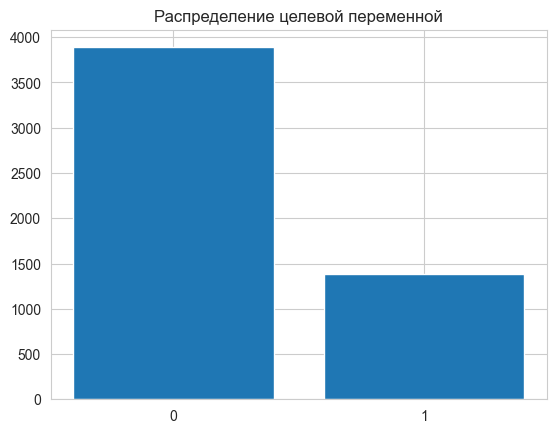

In [206]:
this_data = data[target_column].value_counts()
plt.bar(this_data.index.values, this_data.values)
plt.xticks(this_data.index.values)
plt.title('Распределение целевой переменной')
plt.show()

In [207]:
print(f'Количество объектов класса 0: {data[target_column].value_counts().values[0]}')
print(f'Количество объектов класса 1: {data[target_column].value_counts().values[1]}')
print()
print(f'Доля объектов класса 0: {round(100 * data[target_column].value_counts().values[0] / data[target_column].count(), 2)}%')
print(f'Доля объектов класса 1: {round(100 * data[target_column].value_counts().values[1] / data[target_column].count(), 2)}%')

Количество объектов класса 0: 3889
Количество объектов класса 1: 1384

Доля объектов класса 0: 73.75%
Доля объектов класса 1: 26.25%


Данное распределение НЕ является НЕ сбалансированным (если мы считаем, что несбалансированность начинается с соотношения 20 к 1)

# Применение линейных моделей

### Создание pipline

В задании сказано "Для one-hot-encoding'a **можно** испльзовать комбинацию LabelEncoder + OneHotEncoder"

Можно, но не обязательно. Я считаю это излишним, так что использовал только OneHotEncoder.

In [208]:
X = data.drop(columns=target_column)
y = data[target_column]

In [209]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer

# препроцессор, который будет обрабатывать и числовые, и категориальные признаки
preprocessor = make_column_transformer(
    (StandardScaler(), numerical_columns),  # нормализация числовых значений
    (OneHotEncoder(), catigorial_columns)  # OneHotEncoder для категориальных признаков
)

# основной pipline
pipeline = make_pipeline(
    preprocessor,
    LogisticRegression()
)

pipeline.fit(X, y)
pipeline.score(X, y)

0.8056135027498578

### GridSearchCV

In [211]:
from sklearn.model_selection import GridSearchCV

In [212]:
# param = {'logisticregression__C': [100000, 10, 0.0001]}
# param = {'logisticregression__C': [100, 10, 1, 0.1, 0.01, 0.001]}
param = {'logisticregression__C': [10000000/10**i for i in range(14)]}

model = GridSearchCV(estimator=pipeline,
                     param_grid=param,
                     cv=10,
                     scoring='roc_auc',
                     n_jobs=-1)
model.fit(X, y)
None

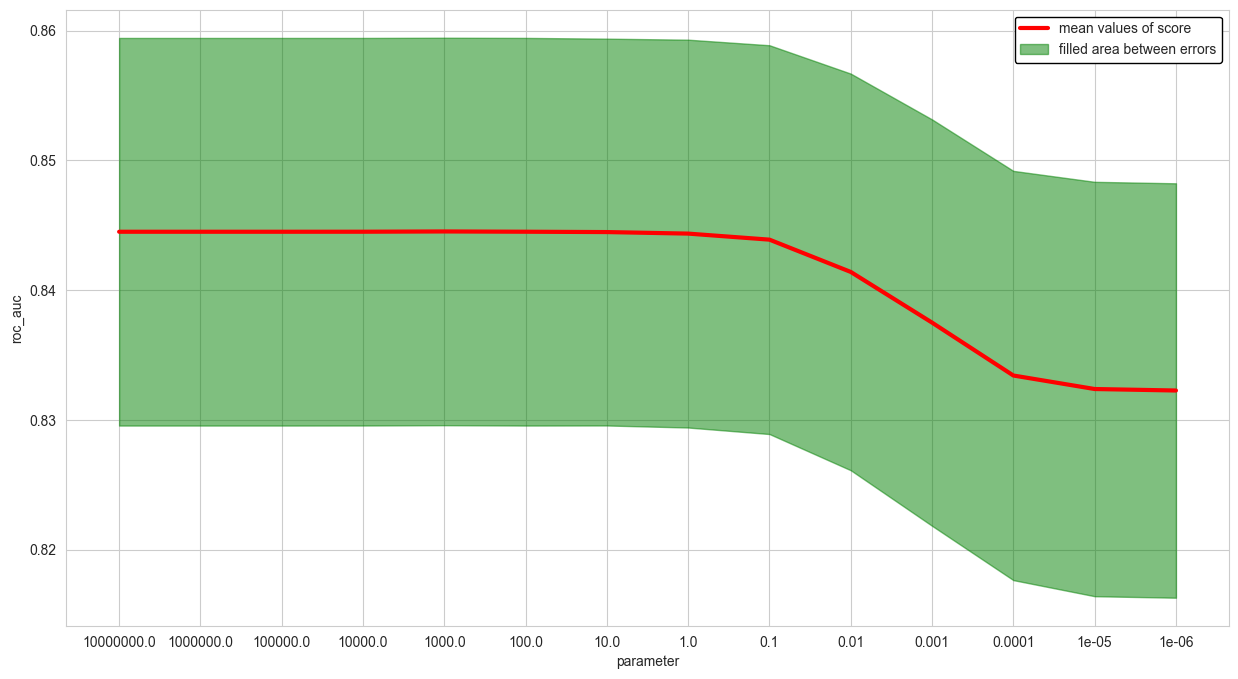

In [213]:
means = model.cv_results_['mean_test_score']
error = model.cv_results_['std_test_score']
grid = list(range(len(means)))
# grid = param['logisticregression__C']

plt.figure(figsize=(15,8))

plt.plot(grid, means, label='mean values of score', color='red', lw=3)
plt.fill_between(grid, means - error, means + error, color='green', label='filled area between errors', alpha=0.5)

plt.xticks(grid, param['logisticregression__C'])

legend_box = plt.legend(framealpha=1).get_frame()
legend_box.set_facecolor("white")
legend_box.set_edgecolor("black")
plt.xlabel('parameter')
plt.ylabel('roc_auc')
plt.show()

Лучшее значение C:

In [214]:
model.best_params_

{'logisticregression__C': 1000.0}

Запомним лучшую модель

In [215]:
best_model = model.best_estimator_

# Предсказание

In [216]:
X_test

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod
0,42,56.10,2386.85,Male,0,Yes,No,Yes,Yes,DSL,Yes,No,No,No,No,No,One year,No,Credit card (automatic)
1,29,98.50,3004.15,Male,1,Yes,No,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check
2,9,76.25,684.85,Male,0,No,No,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check
3,67,74.00,4868.4,Female,0,Yes,Yes,Yes,Yes,DSL,Yes,Yes,No,Yes,Yes,No,Two year,No,Credit card (automatic)
4,71,20.10,1389.6,Female,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Bank transfer (automatic)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1756,71,105.15,7555,Female,0,Yes,No,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Two year,Yes,Bank transfer (automatic)
1757,13,20.85,272.35,Female,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check
1758,2,91.45,171.45,Male,0,Yes,No,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,No,Month-to-month,Yes,Electronic check
1759,19,89.10,1620.8,Female,0,Yes,No,Yes,Yes,Fiber optic,No,Yes,No,No,No,Yes,Month-to-month,Yes,Electronic check


In [17]:
X_test = pd.read_csv('./test.csv')
submission = pd.read_csv('./submission.csv')

best_model.predict_proba(X_test)

submission['Churn'] =best_model.predict_proba(X_test)[:, 1]
submission.to_csv('./my_submission.csv')

ValueError: could not convert string to float: ' '